<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW3_Classification_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 3. Линейная классификация. Работа с признаками**

### **Оценивание и штрафы**

Кака всегда - каждая из задач имеет «стоимость» (указана в скобках около задачи).

В задании три части:

- Часть 1 (2.5 балла): написание логистической регрессии своими руками
- Часть 2 (5 баллов): различные методы отбора признаков
- Часть 3 (3.5 балла): обучение моделей классификации на текстах

Всего за задание можно получить 11 баллов, но:

**Балл за задание = min{ваш балл, 10}.**

In [1]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


# **Часть 1. Логистическая регрессия своими руками (2.5 балла)**

## **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1 балл). Градиентного спуска**

**Задание 1.2 (1 балл). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [2]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        if self.w0 is None:
            self.w = np.zeros(X.shape[1])
        else:
            self.w = self.w0.copy()

        self.loss_history = []

        for iter_num in range(self.max_iter):
            if self.gd_type == 'stochastic':
                idx = np.random.randint(X.shape[0])
                X_batch = X[idx:idx+1]
                y_batch = y[idx:idx+1]
            else:
                X_batch = X
                y_batch = y

            self.loss_history.append(self.calc_loss(X, y))
            w_prev = self.w.copy()
            grad = self.calc_gradient(X_batch, y_batch)
            self.w -= self.eta * grad
            if np.linalg.norm(self.w - w_prev) < self.tolerance:
                break

        return self


    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')

        return self.sigmoid(X @ self.w)


    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')

        return (self.predict_proba(X) >= 0.5).astype(int)

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        p = self.sigmoid(X @ self.w)
        grad = X.T @ (p - y) / len(y)

        return grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        p = self.sigmoid(X @ self.w)
        loss = -np.mean(y * np.log(p + 1e-15) + (1 - y) * np.log(1 - p + 1e-15))

        return loss

Теперь проверим работу вашего класса на синтетических данных.

In [3]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


In [4]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

Accuracy scores:
Full GD: 0.8486
SGD: 0.8194
Sklearn: 0.8487


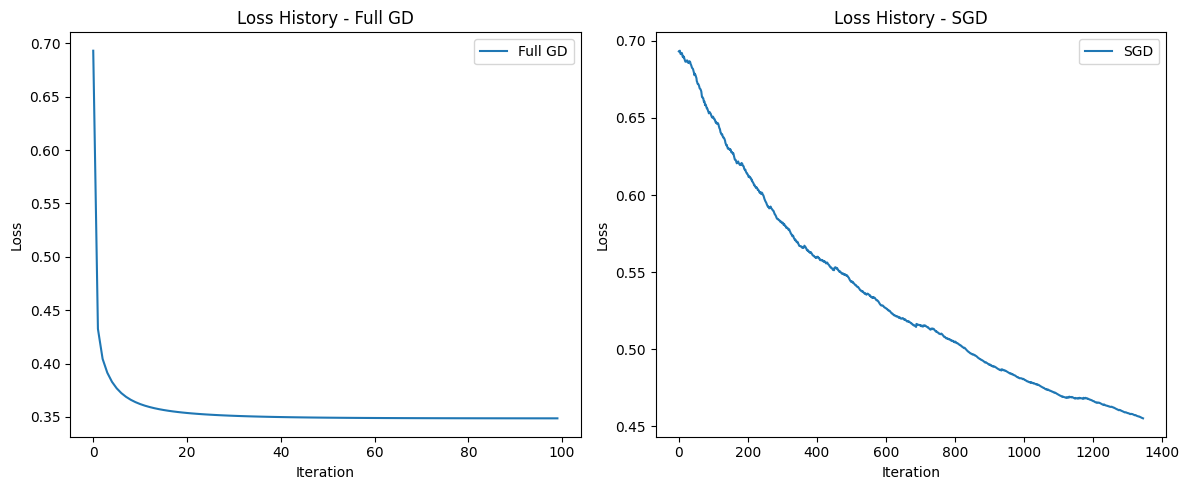

In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt


model_full = LogReg(gd_type='full', eta=0.1, max_iter=100)
model_full.fit(X_train, y_train)

model_sgd = LogReg(gd_type='stochastic', eta=0.0001, max_iter=10000)
model_sgd.fit(X_train, y_train)

sklearn_model = LogisticRegression()
sklearn_model.fit(X_train, y_train)

pred_full = model_full.predict(X_test)
pred_sgd = model_sgd.predict(X_test)
pred_sklearn = sklearn_model.predict(X_test)

print("Accuracy scores:")
print(f"Full GD: {accuracy_score(y_test, pred_full):.4f}")
print(f"SGD: {accuracy_score(y_test, pred_sgd):.4f}")
print(f"Sklearn: {accuracy_score(y_test, pred_sklearn):.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(model_full.loss_history, label='Full GD')
plt.title('Loss History - Full GD')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_sgd.loss_history, label='SGD')
plt.title('Loss History - SGD')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

## **Задание 2 (0.5 балла)**

Обучите логистическую регрессию на синтетических данных.

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

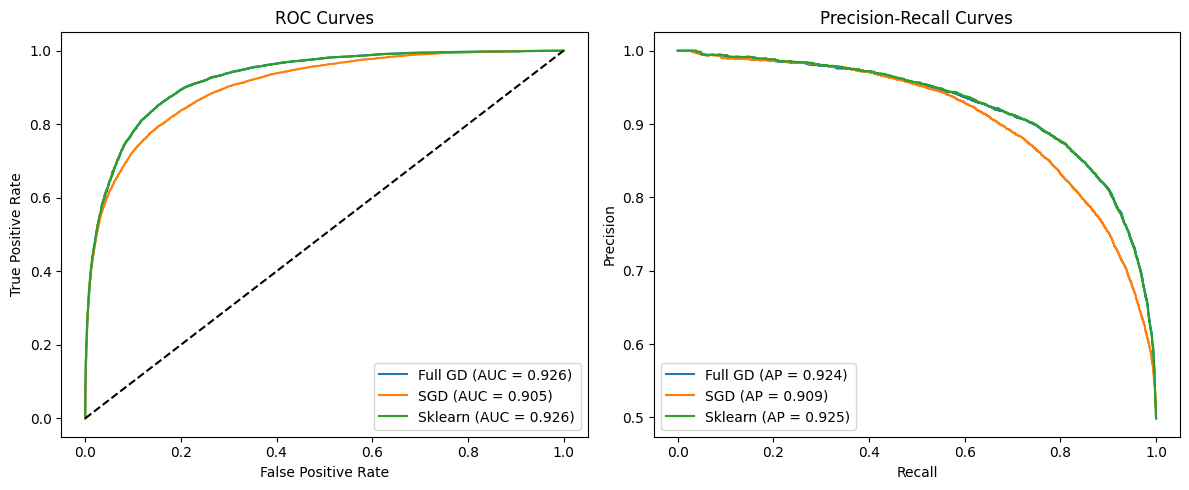


Metrics comparison:
  Model  ROC-AUC   PR-AUC
Full GD 0.925812 0.924411
    SGD 0.904755 0.908719
Sklearn 0.925902 0.924976


In [6]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

proba_full = model_full.predict_proba(X_test)
proba_sgd = model_sgd.predict_proba(X_test)
proba_sklearn = sklearn_model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
fpr_full, tpr_full, _ = roc_curve(y_test, proba_full)
roc_auc_full = auc(fpr_full, tpr_full)
plt.plot(fpr_full, tpr_full, label=f'Full GD (AUC = {roc_auc_full:.3f})')

fpr_sgd, tpr_sgd, _ = roc_curve(y_test, proba_sgd)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)
plt.plot(fpr_sgd, tpr_sgd, label=f'SGD (AUC = {roc_auc_sgd:.3f})')

fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test, proba_sklearn)
roc_auc_sklearn = auc(fpr_sklearn, tpr_sklearn)
plt.plot(fpr_sklearn, tpr_sklearn, label=f'Sklearn (AUC = {roc_auc_sklearn:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()


plt.subplot(1, 2, 2)
precision_full, recall_full, _ = precision_recall_curve(y_test, proba_full)
pr_auc_full = average_precision_score(y_test, proba_full)
plt.plot(recall_full, precision_full, label=f'Full GD (AP = {pr_auc_full:.3f})')

precision_sgd, recall_sgd, _ = precision_recall_curve(y_test, proba_sgd)
pr_auc_sgd = average_precision_score(y_test, proba_sgd)
plt.plot(recall_sgd, precision_sgd, label=f'SGD (AP = {pr_auc_sgd:.3f})')

precision_sklearn, recall_sklearn, _ = precision_recall_curve(y_test, proba_sklearn)
pr_auc_sklearn = average_precision_score(y_test, proba_sklearn)
plt.plot(recall_sklearn, precision_sklearn, label=f'Sklearn (AP = {pr_auc_sklearn:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()

plt.tight_layout()
plt.show()

metrics_df = pd.DataFrame({
    'Model': ['Full GD', 'SGD', 'Sklearn'],
    'ROC-AUC': [roc_auc_full, roc_auc_sgd, roc_auc_sklearn],
    'PR-AUC': [pr_auc_full, pr_auc_sgd, pr_auc_sklearn]
})

print("\nMetrics comparison:")
print(metrics_df.to_string(index=False))

# **Часть 2. Отбор признаков (5 баллов)**

Перейдём к еще одной важной части процесса работы с данными — отбору признаков. Он нужен в следующих случаях:
- Мы хотим сократить время вычислений;
- Мы хотим избежать переобучения;
- Мы хотим попытаться улучшить качество модели за счет уменьшения признакового пространства;

В этой части мы попробуем применить несколько подходов для отбора признаков и оценим, как они влияют на качество модели и сколько времени занимают.

**Данные** \

Будем использовать датасет [об обращениях клиентов по страховым случаям](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data?select=train.csv). Скачайте его с Kaggle (файл `train.csv`).

Задача представляет собой бинарную классификациюю — воспользуется ли клиент страховкой на авто в ближайший год.

In [7]:
PATH_TO_DATASET = '/content/drive/MyDrive/train.csv'

data = pd.read_csv(PATH_TO_DATASET, index_col=0)
target = data.target.values

data = data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Задание 3. (0.25 балла)**

Прежде всего — в данных много категориальных признаков.

- Закодируйте их с помощью one-hot кодирования. Категориальные признаки отмечены постфиксом `cat`;
- Исходные колонки с категориальными признаками удалите;
- Зафиксируйте, сколько признаков получилось;

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

cat_features = [col for col in data.columns if col.endswith('cat')]
num_features = [col for col in data.columns if not col.endswith('cat')]

print("Категориальные признаки:", cat_features)
print("Количество категориальных признаков:", len(cat_features))
print("\nЧисловые признаки:", num_features)
print("Количество числовых признаков:", len(num_features))

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded_features = encoder.fit_transform(data[cat_features])

feature_names = []
for i, feature in enumerate(cat_features):
    feature_names.extend([f"{feature}_{val}" for val in encoder.categories_[i]])

encoded_df = pd.DataFrame(encoded_features, columns=feature_names, index=data.index)

final_data = pd.concat([data[num_features], encoded_df], axis=1)

print("\nРазмерность данных:")
print(f"Исходная размерность: {data.shape}")
print(f"Итоговая размерность: {final_data.shape}")
print(f"\nКоличество признаков после кодирования: {final_data.shape[1]}")

X_train, X_test, y_train, y_test = train_test_split(
    final_data,
    target,
    test_size=0.2,
    random_state=124
)

print("\nРазмерности обучающей и тестовой выборок:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

feature_names_all = list(final_data.columns)

Категориальные признаки: ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']
Количество категориальных признаков: 14

Числовые признаки: ['ps_ind_01', 'ps_ind_03', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
Количество числовых признако

### **Задание 4 (1 балл)**

Обучим несколько моделей, перечисленных ниже. В качестве метрики будем использовать ROC-AUC.

**Задание 4.1**

- Обучите модель логистической регрессии. Замерьте скорость обучения модели
- Обучите метод опорных векторов
- Обучите метод k ближайших соседей
- Посчитайте качество моделей (ROC-AUC) на тестовой выборке

**Задание 4.2**

Для каждой из трех моделей (логистическая регрессия, SVM, KNN) подберите при помощи GridSearchCV на тренировочных данных оптимальные гиперпараметры:
- Для логистической регрессии: C, class_weight
- Для SVM: C, kernel, class_weight
- Для KNN: n_neighbors, weights

Затем посчитайте качество моделей на тестовой выборке.

В заданиях 4.1 и 4.2 замеряйте время обучения моделей.


In [ ]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# Задание 4.1
results = {}

# 1. Логистическая регрессия
print("Обучение логистической регрессии...")
start_time = time.time()
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr_time = time.time() - start_time
lr_roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
results['LogReg'] = {'time': lr_time, 'roc_auc': lr_roc_auc}

# 2. SVM
print("Обучение SVM...")
start_time = time.time()
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)
svm_time = time.time() - start_time
svm_roc_auc = roc_auc_score(y_test, svm.predict_proba(X_test)[:, 1])
results['SVM'] = {'time': svm_time, 'roc_auc': svm_roc_auc}

# 3. KNN
print("Обучение KNN...")
start_time = time.time()
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_time = time.time() - start_time
knn_roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
results['KNN'] = {'time': knn_time, 'roc_auc': knn_roc_auc}

# Вывод результатов задания 4.1
print("\nРезультаты базовых моделей:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"Время обучения: {metrics['time']:.2f} сек")
    print(f"ROC-AUC: {metrics['roc_auc']:.4f}\n")

# Задание 4.2

# 1. Логистическая регрессия
print("Подбор параметров для логистической регрессии...")
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced']
}
start_time = time.time()
lr_grid = GridSearchCV(LogisticRegression(random_state=42),
                      lr_params,
                      cv=3,
                      scoring='roc_auc')
lr_grid.fit(X_train, y_train)
lr_grid_time = time.time() - start_time
lr_grid_roc_auc = roc_auc_score(y_test, lr_grid.predict_proba(X_test)[:, 1])

# 2. SVM
print("Подбор параметров для SVM...")
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': [None, 'balanced']
}
start_time = time.time()
svm_grid = GridSearchCV(SVC(probability=True, random_state=42),
                       svm_params,
                       cv=3,
                       scoring='roc_auc')
svm_grid.fit(X_train, y_train)
svm_grid_time = time.time() - start_time
svm_grid_roc_auc = roc_auc_score(y_test, svm_grid.predict_proba(X_test)[:, 1])

# 3. KNN
print("Подбор параметров для KNN...")
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
start_time = time.time()
knn_grid = GridSearchCV(KNeighborsClassifier(),
                       knn_params,
                       cv=3,
                       scoring='roc_auc')
knn_grid.fit(X_train, y_train)
knn_grid_time = time.time() - start_time
knn_grid_roc_auc = roc_auc_score(y_test, knn_grid.predict_proba(X_test)[:, 1])

print("\nРезультаты после подбора гиперпараметров:")
print("\nЛогистическая регрессия:")
print(f"Лучшие параметры: {lr_grid.best_params_}")
print(f"Время подбора: {lr_grid_time:.2f} сек")
print(f"ROC-AUC: {lr_grid_roc_auc:.4f}")

print("\nSVM:")
print(f"Лучшие параметры: {svm_grid.best_params_}")
print(f"Время подбора: {svm_grid_time:.2f} сек")
print(f"ROC-AUC: {svm_grid_roc_auc:.4f}")

print("\nKNN:")
print(f"Лучшие параметры: {knn_grid.best_params_}")
print(f"Время подбора: {knn_grid_time:.2f} сек")
print(f"ROC-AUC: {knn_grid_roc_auc:.4f}")

### **Встроенные методы**

**Заметим, что:**

- Время обучения моделей отличается между собой.
- Несмотря на то, что признаков много, качество модели не очень хорошее.


Попробуем решить проблемы — улучшить качество и при этом сократить пространство признаков и, соответственно, время обучения моделей.



**Отбор признаков встроеным методом.**

Начнём с отбора признаков с помощью линейной модели. Делая это, мы используем факт:
> веса линейной модели отражают  вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков.

Такой метод отбора называются встроенным в модель методом, так как он заложен в особенности модели.

**Важно:** применение этого подхода требует машстабирования признаков (подумайте, почему). Вы можете использовать приведение к стандартному нормальному распределению (`StandardScaler`) с параметрами или MinMax преобразование (`MinMaxScaler`).

### **Задание 5 (0.75 балла)**

Оставьте 150 признаков с наибольшими по модулю весами после обучения логистической регрессии.

- Замерьте скорость такого отбора признаков. (0.2 балла)

- Обучите логистическую регрессию на исходных признаках. Из них оставьте 150 лучших (с наибольшими по модулю весами).
- Масштабируйте данные — все, кроме категориальных и бинарных признаков. Зафиксируйте, сколько признаков пришлось масштабировать. (0.25 балла)
- Обучите новую модель на 150 признаках и оцените её качество. (0.15 балла)




In [10]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

binary_features = [col for col in final_data.columns if '_bin' in col]
categorical_features = [col for col in final_data.columns if '_cat' in col]
features_to_scale = [col for col in final_data.columns
                    if col not in binary_features
                    and col not in categorical_features]

print(f"Количество признаков для масштабирования: {len(features_to_scale)}")

scaler = StandardScaler()
scaled_features = final_data.copy()
scaled_features[features_to_scale] = scaler.fit_transform(final_data[features_to_scale])

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    scaled_features, target, test_size=0.2, random_state=124
)

start_time = time.time()

lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': np.abs(lr.coef_[0])
})

top_150_features = feature_importance.nlargest(150, 'importance')['feature'].tolist()

selection_time = time.time() - start_time
print(f"\nВремя отбора признаков: {selection_time:.2f} секунд")

X_train_selected = X_train_scaled[top_150_features]
X_test_selected = X_test_scaled[top_150_features]

start_time = time.time()
lr_selected = LogisticRegression(random_state=42)
lr_selected.fit(X_train_selected, y_train)
training_time = time.time() - start_time

y_pred_proba = lr_selected.predict_proba(X_test_selected)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nРезультаты:")
print(f"Исходное количество признаков: {scaled_features.shape[1]}")
print(f"Количество отобранных признаков: {len(top_150_features)}")
print(f"ROC-AUC на отобранных признаках: {roc_auc:.4f}")
print(f"Время обучения финальной модели: {training_time:.2f} секунд")

print("\nТоп-10 самых важных признаков:")
print(feature_importance.nlargest(10, 'importance'))

selected_binary = [f for f in top_150_features if '_bin' in f]
selected_categorical = [f for f in top_150_features if '_cat' in f]
selected_scaled = [f for f in top_150_features if f in features_to_scale]

print("\nСостав отобранных признаков:")
print(f"Бинарные: {len(selected_binary)}")
print(f"Категориальные: {len(selected_categorical)}")
print(f"Масштабированные: {len(selected_scaled)}")

Количество признаков для масштабирования: 26

Время отбора признаков: 8.75 секунд

Результаты:
Исходное количество признаков: 227
Количество отобранных признаков: 150
ROC-AUC на отобранных признаках: 0.6390
Время обучения финальной модели: 5.15 секунд

Топ-10 самых важных признаков:
              feature  importance
52    ps_ind_05_cat_0    0.525174
54    ps_ind_05_cat_2    0.363708
49    ps_ind_04_cat_0    0.327546
51   ps_ind_05_cat_-1    0.323006
87    ps_car_04_cat_9    0.322872
55    ps_ind_05_cat_3    0.315240
13      ps_ind_17_bin    0.296850
67    ps_car_01_cat_7    0.287348
109  ps_car_07_cat_-1    0.283472
75   ps_car_03_cat_-1    0.270899

Состав отобранных признаков:
Бинарные: 6
Категориальные: 137
Масштабированные: 7


### **Бонус (0.25 балла)**

Попробуйте реализовать итеративный отбор признаков, а именно:

1) Сначала отобрать около 200 признаков (действуя как в задании выше)

2) Потом повторить процедуру для отбора 150 признаков из 200 (снова действуя как в задании выше)

In [11]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

def select_features(X_train, X_test, y_train, n_features):
    lr = LogisticRegression(random_state=42)
    lr.fit(X_train, y_train)

    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': np.abs(lr.coef_[0])
    })

    top_features = feature_importance.nlargest(n_features, 'importance')['feature'].tolist()

    return X_train[top_features], X_test[top_features], top_features

binary_features = [col for col in final_data.columns if '_bin' in col]
categorical_features = [col for col in final_data.columns if '_cat' in col]
features_to_scale = [col for col in final_data.columns
                    if col not in binary_features
                    and col not in categorical_features]

print(f"Количество признаков для масштабирования: {len(features_to_scale)}")

scaler = StandardScaler()
scaled_features = final_data.copy()
scaled_features[features_to_scale] = scaler.fit_transform(final_data[features_to_scale])

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    scaled_features, target, test_size=0.2, random_state=124
)

print("\nШаг 1: Отбор 200 признаков")
start_time = time.time()
X_train_200, X_test_200, features_200 = select_features(X_train_scaled, X_test_scaled, y_train, 200)
time_200 = time.time() - start_time

lr_200 = LogisticRegression(random_state=42)
lr_200.fit(X_train_200, y_train)
y_pred_proba_200 = lr_200.predict_proba(X_test_200)[:, 1]
roc_auc_200 = roc_auc_score(y_test, y_pred_proba_200)

print("\nШаг 2: Отбор 150 признаков из 200")
start_time = time.time()
X_train_150, X_test_150, features_150 = select_features(X_train_200, X_test_200, y_train, 150)
time_150 = time.time() - start_time

lr_150 = LogisticRegression(random_state=42)
lr_150.fit(X_train_150, y_train)
y_pred_proba_150 = lr_150.predict_proba(X_test_150)[:, 1]
roc_auc_150 = roc_auc_score(y_test, y_pred_proba_150)

print("\nРезультаты:")
print(f"Исходное количество признаков: {scaled_features.shape[1]}")
print(f"\nПервый этап (200 признаков):")
print(f"Время отбора: {time_200:.2f} секунд")
print(f"ROC-AUC: {roc_auc_200:.4f}")

print(f"\nВторой этап (150 признаков):")
print(f"Время отбора: {time_150:.2f} секунд")
print(f"ROC-AUC: {roc_auc_150:.4f}")

selected_binary = [f for f in features_150 if '_bin' in f]
selected_categorical = [f for f in features_150 if '_cat' in f]
selected_scaled = [f for f in features_150 if f in features_to_scale]

print("\nСостав финальных 150 признаков:")
print(f"Бинарные: {len(selected_binary)}")
print(f"Категориальные: {len(selected_categorical)}")
print(f"Масштабированные: {len(selected_scaled)}")

feature_importance_final = pd.DataFrame({
    'feature': features_150,
    'importance': np.abs(lr_150.coef_[0])
})

print("\nТоп-10 самых важных признаков из финальных 150:")
print(feature_importance_final.nlargest(10, 'importance'))

Количество признаков для масштабирования: 26

Шаг 1: Отбор 200 признаков

Шаг 2: Отбор 150 признаков из 200

Результаты:
Исходное количество признаков: 227

Первый этап (200 признаков):
Время отбора: 7.25 секунд
ROC-AUC: 0.6386

Второй этап (150 признаков):
Время отбора: 8.42 секунд
ROC-AUC: 0.6391

Состав финальных 150 признаков:
Бинарные: 6
Категориальные: 137
Масштабированные: 7

Топ-10 самых важных признаков из финальных 150:
             feature  importance
0    ps_ind_05_cat_0    0.520847
8    ps_car_01_cat_7    0.339498
1    ps_ind_05_cat_2    0.339136
4    ps_car_04_cat_9    0.332504
3    ps_ind_04_cat_0    0.327001
2   ps_ind_05_cat_-1    0.307696
14   ps_car_09_cat_0    0.302866
5    ps_ind_05_cat_3    0.299318
6      ps_ind_17_bin    0.293986
10  ps_car_03_cat_-1    0.260015


### **Задание 6 (0.5 балла)**

Также можно задать отбор признаков, используя другия свойства модели. Вспомним, что L1-регуляризация тоже умеет отбирать признаки.

- Обучите модель на исходных данных. Подберите по сетке (GridSearch) наилучшее значение коэффициента регуляризации C. (0.1 балла)

- Посмотрите сколько признаков отобрала модель с найденным оптимальным C?
  - Сначала посчитайте только число ненулевых весов
  - Затем посчитайте число весов, которые после округления до двух знаков после запятой не равны нулю (0.25 балла)

Удалось ли отобрать 150 признаков за 1 шаг? (0.05 балла)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np


X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    scaled_features, target, test_size=0.2, random_state=124
)


param_grid = {'C': [0.01, 1, 100]}
lr = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_scaled, y_train)

best_C = grid_search.best_params_['C']
print(f"Оптимальное значение C: {best_C}")

best_model = LogisticRegression(penalty='l1', C=best_C, solver='liblinear', random_state=42)
best_model.fit(X_train_scaled, y_train)

non_zero_weights = np.sum(best_model.coef_[0] != 0)
print(f"\nКоличество ненулевых весов: {non_zero_weights}")

rounded_non_zero = np.sum(np.round(best_model.coef_[0], 2) != 0)
print(f"Количество ненулевых весов после округления до двух знаков: {rounded_non_zero}")

success = rounded_non_zero <= 150
print(f"\nУдалось ли отобрать 150 признаков за 1 шаг? {'Да' if success else 'Нет'}")

y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC модели с L1-регуляризацией: {roc_auc:.4f}")

feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': np.abs(best_model.coef_[0])
})
print("\nТоп-10 самых важных признаков:")
print(feature_importance.nlargest(10, 'importance'))

Оптимальное значение C: 1

Количество ненулевых весов: 205
Количество ненулевых весов после округления до двух знаков: 182

Удалось ли отобрать 150 признаков за 1 шаг? Нет
ROC-AUC модели с L1-регуляризацией: 0.6383

Топ-10 самых важных признаков:
              feature  importance
75   ps_car_03_cat_-1    1.779349
76    ps_car_03_cat_0    1.620568
77    ps_car_03_cat_1    1.544520
48   ps_ind_04_cat_-1    0.965315
51   ps_ind_05_cat_-1    0.609282
43   ps_ind_02_cat_-1    0.565626
54    ps_ind_05_cat_2    0.480410
185  ps_car_11_cat_63    0.467598
85    ps_car_04_cat_7    0.446324
163  ps_car_11_cat_41    0.405755


### **Методы фильтрации**

Также можно отбирать признаки, применяя методы математической статистики. А именно, в нашем случае, через подсчёт некоторой функции для каждого признака. На основании значений этой функции (она называется *статистикой*) мы можем оставлять наиболее важные признаки. Методы этого семейства называют *фильтрационными* или *filter methods*.

**Что проверяем:**

Равны ли математические ожидания (то есть выборочные средние) распределений признака для двух разных классов? Если они различаются, значит и сами распределения разные. И можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и значение статистики маленькое, то и признак бесполезен.


Для проверки будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ s^2_+ + n_- s^2_-}{n_+ + n_-}}},$$

где $\mu$, $s$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

**Примечание:** Если у вас была данная тема на курсе по математической статистике, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях.

Хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и $n$ велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются.

Для отбора признаков по t-статистике мы возьмём признаки с наибольшим значением статистики.

### **Задание 7 (1 балла)**

-  Масштабируйте признаки исходного датасета — все, кроме категориальных и бинарных.
- Выделите непрерывные признаки (те, которые масштабировали)
- Посчитайте значения t-статистики. Оставьте ***половину*** признаков с наибольшим значением статистики, объедините их с категориальными и бинарными.
- Обучите модель логистической регрессии и замерьте качество.

Не забудьте замерить скорость отбора признаков в этом случаев.

In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import time

binary_features = [col for col in final_data.columns if '_bin' in col]
categorical_features = [col for col in final_data.columns if '_cat' in col]
continuous_features = [col for col in final_data.columns
                      if col not in binary_features
                      and col not in categorical_features]

start_time = time.time()

scaled_features = final_data.copy()
scaler = StandardScaler()
scaled_features[continuous_features] = scaler.fit_transform(final_data[continuous_features])

def calculate_t_statistic(X, y):
    class_0 = X[y == 0]
    class_1 = X[y == 1]

    n0, n1 = len(class_0), len(class_1)
    mu0, mu1 = np.mean(class_0, axis=0), np.mean(class_1, axis=0)
    var0, var1 = np.var(class_0, axis=0), np.var(class_1, axis=0)

    pooled_se = np.sqrt((n0 * var0 + n1 * var1) / (n0 + n1))
    t_stat = np.abs(mu0 - mu1) / pooled_se

    return t_stat

X_continuous = scaled_features[continuous_features]
t_statistics = calculate_t_statistic(X_continuous, target)

feature_scores = pd.DataFrame({
    'feature': continuous_features,
    't_statistic': t_statistics
})

n_select = len(continuous_features) // 2
selected_continuous = feature_scores.nlargest(n_select, 't_statistic')['feature'].tolist()

final_features = selected_continuous + binary_features + categorical_features

X_selected = scaled_features[final_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, target, test_size=0.2, random_state=42)

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

y_pred_proba = lr.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

selection_time = time.time() - start_time

print(f"Количество непрерывных признаков: {len(continuous_features)}")
print(f"Количество отобранных непрерывных признаков: {n_select}")
print(f"Общее количество итоговых признаков: {len(final_features)}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Время отбора признаков: {selection_time:.2f} секунд")

print("\nТоп-10 признаков по t-статистике:")
print(feature_scores.nlargest(10, 't_statistic'))

Количество непрерывных признаков: 26
Количество отобранных непрерывных признаков: 13
Общее количество итоговых признаков: 214
ROC-AUC: 0.6322
Время отбора признаков: 16.19 секунд

Топ-10 признаков по t-статистике:
             feature  t_statistic
ps_car_13  ps_car_13     0.288031
ps_car_12  ps_car_12     0.207144
ps_reg_02  ps_reg_02     0.185811
ps_reg_03  ps_reg_03     0.164902
ps_car_15  ps_car_15     0.147693
ps_reg_01  ps_reg_01     0.122166
ps_ind_15  ps_ind_15     0.114787
ps_ind_01  ps_ind_01     0.099111
ps_ind_03  ps_ind_03     0.044610
ps_ind_14  ps_ind_14     0.039717


### **Методы-обёртки**

### **Задание 8 (бонус, 1 балл)**


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди каждый из признаков и смотрим, как это влияет на качество модели, обученной без удаленного признака. Удаляем признаки таким жадным способом.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур много. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо.

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 150 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


### **Задание 9 (0.25 балла)**

Подведите итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

# **Часть 3. Обучение моделей на текстовых данных. (3.5 балла)**

 ### **Подготовка данных из реального мира.**

Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [ ]:
from sklearn.model_selection import train_test_split

PATH = ...
data = pd.read_csv(PATH)

data.head()

### **Задание 10. Базовая предобработка (0.5 баллов).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

- Проанализируйте количество уникальных значений в числовых столбцах. Сделайте выводы.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

- Проанализируйте соотношение классов в целевой переменной. Почему значимо это учитывать?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

- Объедините все три текстовых столбца в один (вам поможет конкатенация строк)

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

- Наконец, поделите данные на тренировочную и тестовую выборки.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

- Обучите логистическую регрессию на полученном наборе. Какое качество `f1` у модели получилось на тестовых данных?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество (`f1`) на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### **Задание 12. Улучшение базовых моделей за счет данных. (0.5 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют (0.5 балла).

Обучайте и логистическую регрессию, и SVC.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Ваши выводы здесь.

### **Задание 14. (0.5 балла)**

Оформите два пайплайна:
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### **Выводы**

Зафиксируйте выводы работы. Проанализируйте, что проделано и какие результаты вы получили. Заполняется в свободной форме.

## Чей кот?

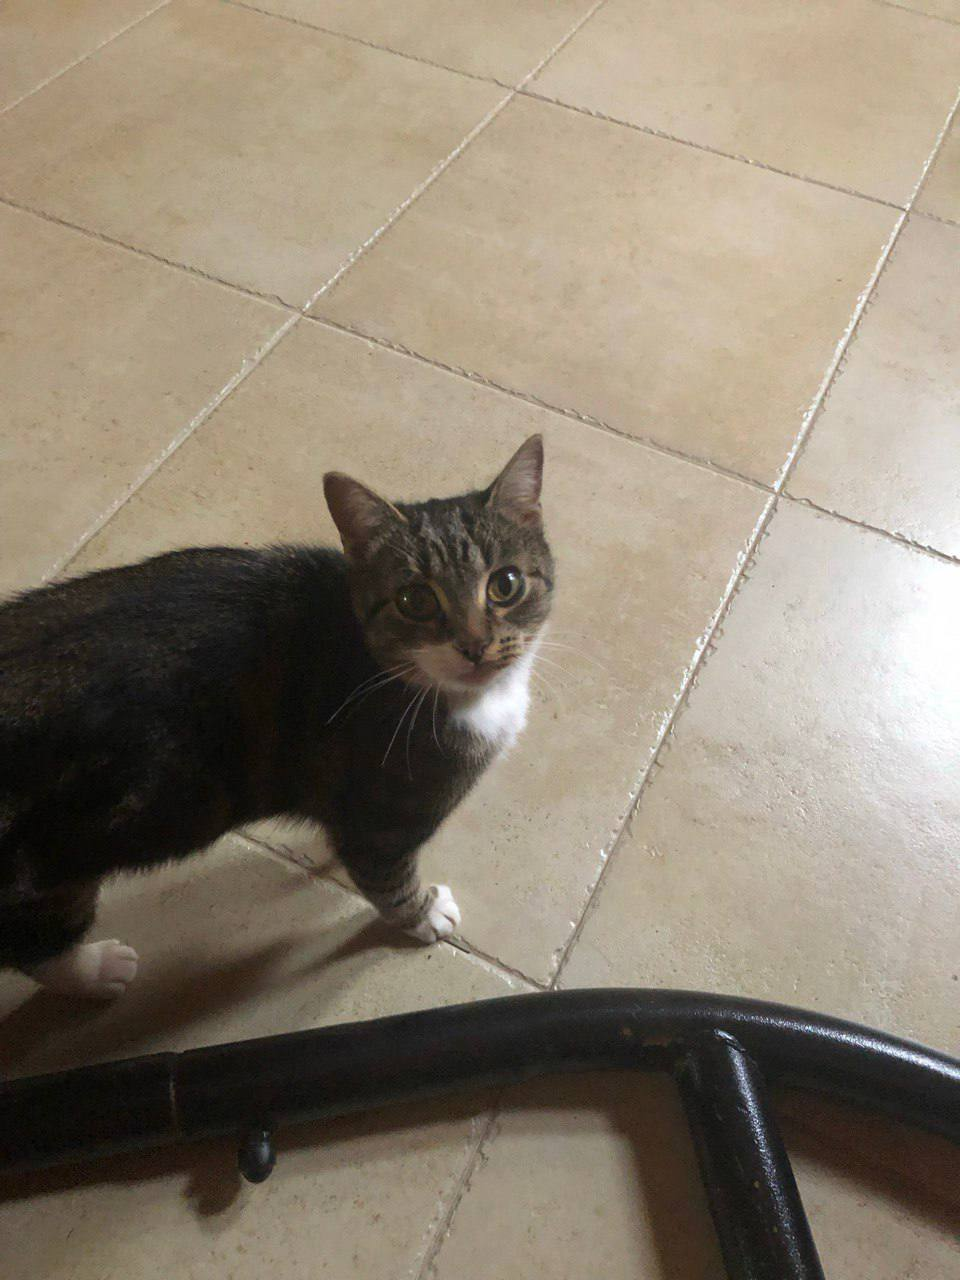